In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.model_selection import train_test_split
import timm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
cifar_dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)

100%|██████████| 170M/170M [00:27<00:00, 6.26MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
subset_size = 5000
cifar_dataset = torch.utils.data.random_split(cifar_dataset, [subset_size, len(cifar_dataset) - subset_size])[0]

In [ ]:
train_set, val_set = train_test_split(cifar_dataset, test_size=0.1, random_state=42)

In [ ]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
class ViT(nn.Module):
    def __init__(self, num_classes=10):
        super(ViT, self).__init__()

        self.model = timm.create_model("vit_small_patch16_224", pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

model = ViT().to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [ ]:
num_epochs = 5
accumulation_steps = 4

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}")

print("Training complete!")

Epoch 1/5, Loss: 0.4806, Accuracy: 0.8500
Epoch 2/5, Loss: 0.6624, Accuracy: 0.8140
Epoch 3/5, Loss: 0.1024, Accuracy: 0.8740
Epoch 4/5, Loss: 0.1147, Accuracy: 0.8820
Epoch 5/5, Loss: 0.3057, Accuracy: 0.8560
Training complete!


In [ ]:
from PIL import Image

In [ ]:
def classify_image(model, image_path, transform, class_labels):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(image)

    _, predicted_class_index = torch.max(output, 1)

    predicted_class_label = class_labels[predicted_class_index.item()]

    return predicted_class_label

In [ ]:
cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

In [ ]:
image_path = "dc.png"
predicted_class_label = classify_image(model, image_path, transform, cifar10_classes)
print(f"The predicted class label for the image is: {predicted_class_label}")

The predicted class label for the image is: cat


In [ ]:
image_path = "abc.png"
predicted_class_label = classify_image(model, image_path, transform, cifar10_classes)
print(f"The predicted class label for the image is: {predicted_class_label}")

The predicted class label for the image is: dog


In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


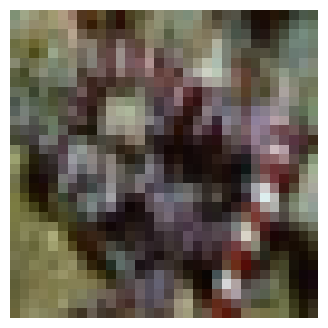

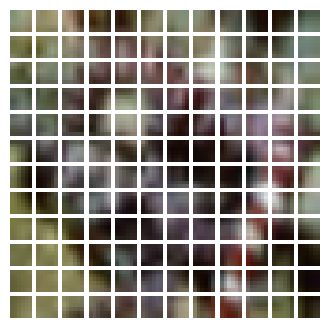

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def run_experiment(model):
    # Using Adam optimizer with weight decay applied manually
    weight_decay = 1e-4  # Define your weight decay value
    learning_rate = 1e-3  # Define your learning rate

    # Apply weight decay manually through L2 regularization in the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Adding L2 regularization to weights manually if needed
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(k=5, name="top-5-accuracy")
        ],
    )

    # Checkpoint callback to save the best model based on validation accuracy
    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    # Training the model
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    # Load the best weights saved during training
    model.load_weights(checkpoint_filepath)

    # Evaluate the model on the test set
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)

    # Print the results
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

# Create your ViT classifier or other model
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 127s 135ms/step - accuracy: 0.0233 - loss: 4.8800 - top-5-accuracy: 0.0676 - val_accuracy: 0.0710 - val_loss: 4.0347 - val_top-5-accuracy: 0.0926
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 135s 132ms/step - accuracy: 0.0587 - loss: 4.1690 - top-5-accuracy: 0.0915 - val_accuracy: 0.1112 - val_loss: 3.7809 - val_top-5-accuracy: 0.0556
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 144s 134ms/step - accuracy: 0.0884 - loss: 3.9273 - top-5-accuracy: 0.0807 - val_accuracy: 0.1672 - val_loss: 3.4848 - val_top-5-accuracy: 0.0424
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 94s 134ms/step - accuracy: 0.1301 - loss: 3.6860 - top-5-accuracy: 0.0579 - val_accuracy: 0.1956 - val_loss: 3.3038 - val_top-5-accuracy: 0.0756
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 134ms/step - accuracy: 0.1666 - loss: 3.4578 - top-5-accuracy: 0.0546 - val_accuracy: 0.2354 - val_loss: 3.0793 - val_top-5-accuracy: 0.0476
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 142s 133ms/step - accuracy: 0.2

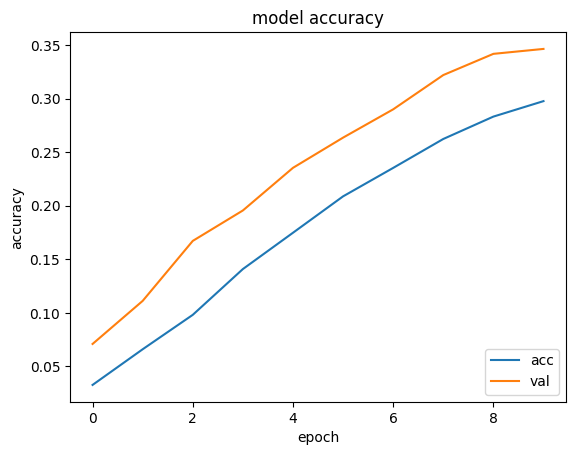

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel ('epoch')
plt.legend(['acc','val'], loc='lower right')
plt.show()

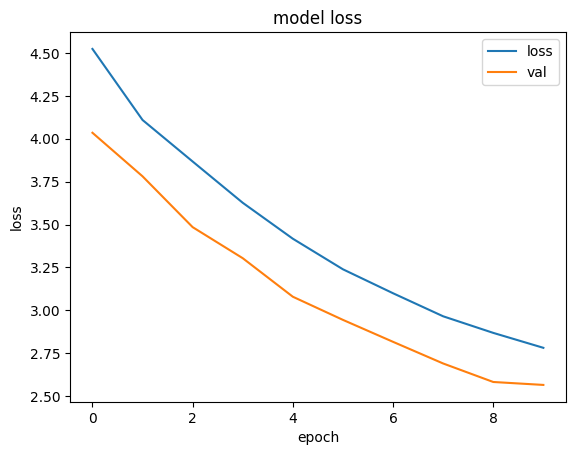

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel ('epoch')
plt.legend(['loss','val'], loc='upper right')
plt.show()

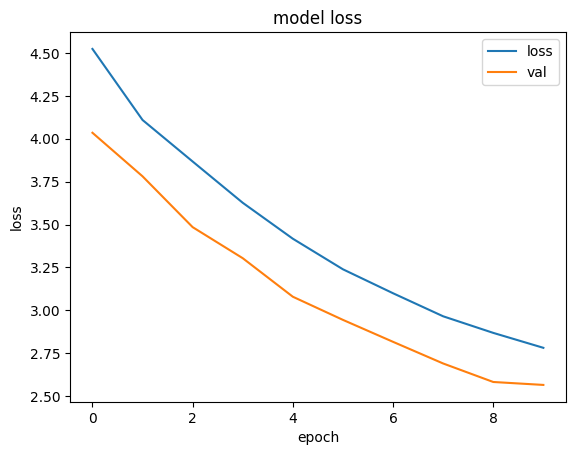

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel ('epoch')
plt.legend(['loss','val'], loc='upper right')
plt.show()

# Tasks (Home)

1. Perfrom Image Classification on FashionMnist
2. Perform Image Classification on Mnist

# Task (Lab)
1. Image Classification on Flowers' images, Dataset available at TF